### 環境初始化

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from IPython.display import Image
import matplotlib.pyplot as plt
import json
import random
import time
import pandas as pd
%matplotlib inline

### 資料集格式範例


檔案標頭
```json
{
    "file": "1-FemaleNoGlasses-Normal",
    "size": 419,
    "fps": 30,
    "marker_path": "dataset/markers/1-FemaleNoGlasses-Normal.csv",
    "video_path": "dataset/YawDD/train/1-FemaleNoGlasses-Normal.avi"
}
```
標記內容
```json
{
    "index": 1,
    "level": "0",
    "mouth_ear": 0.02305602969572012,
    "roll": -2.8421378836556643,
    "yaw": 38.241611421108246,
    "pitch": -11.410418897867203
}
```

### 功能函式

**自訂功能函式**：map(var, in_min, in_max, out_min, out_max)

In [3]:
def map(var, in_min, in_max, out_min, out_max):
    var = float(var)
    if var >= in_max:
        return out_max
    if var <= in_min:
        return out_min
    return (var - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

**讀取資料集且正規化**：readData(file)

In [4]:
def readDataList(file):
    train_list = []
    with open(file, 'r', encoding='utf-8') as f:
        while True:
            line = f.readline()
            if len(line) == 0: break
            file_json = json.loads(line)
            mlist = []
            for i in range(file_json['size']):
                mline = f.readline()
                mjson = json.loads(mline)
                level = map(mjson['level'], 0, 5, 0, 1)
                mar = map(mjson['mar'], 0, 1, 0, 1)
                ear_l = map(mjson['ear_l'], 0, 1, 0, 1)
                ear_r = map(mjson['ear_r'], 0, 1, 0, 1)
                entropy = map(mjson['entropy'], 0, 30, 0, 1)
                # roll = map(mjson['roll'], -50, 50, -1, 1)
                # yaw = map(mjson['yaw'], -50, 50, -1, 1)
                # pitch = map(mjson['pitch'], -50, 50, -1, 1)
                mlist.append(np.array([
                    level,
                    mar,
                    ear_l,
                    ear_r,
                    entropy
                ]))
            train_list.append(np.array(mlist))
    return np.array(train_list)

**產生訓練資料**：buildTrain(train_list, long=300)

In [5]:
def buildTrain(train_list, long=300):
  X_train, Y_train = [], []
  for t in train_list:
    train = np.array(t)
    for i in range(train.shape[0]-long):
      X_train.append(train[i:i+long,1:])
      Y_train.append(train[i+long-1][0])
  return np.array(X_train), np.array(Y_train)

**資料隨機排序**：shuffle(X,Y)

In [6]:
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

**產生驗證資料**：splitData(X, Y, rate)

In [7]:
def splitData(X, Y, rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val

### 主程式

##### 建立訓練資料

In [8]:
train_list = readDataList('train_data.txt')
X_train, Y_train = buildTrain(train_list, 600)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.2)
X_val, Y_val, X_test, Y_test = splitData(X_val, Y_val, 0.5)

C:\Users\kk693\AppData\Local\Temp\ipykernel_37964\1008141229.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(train_list)


In [9]:
print(X_train.shape)
x_train = [None] * 3
x_train[0] = X_train[:, :, 0:1]
x_train[1] = X_train[:, :, 1:2]
x_train[2] = X_train[:, -1:, 2]
print(x_train[0].shape)
print(x_train[1].shape)
print(x_train[2].shape)

(35296, 600, 4)
(35296, 600, 1)
(35296, 600, 1)
(35296, 1)


In [10]:
print(X_val.shape)
x_val = [None] * 3
x_val[0] = X_val[:, :, 0:1]
x_val[1] = X_val[:, :, 1:2]
x_val[2] = X_val[:, -1:, 2]
print(x_val[0].shape)
print(x_val[1].shape)
print(x_val[2].shape)

(4412, 600, 4)
(4412, 600, 1)
(4412, 600, 1)
(4412, 1)


In [11]:
print(X_test.shape)
x_test = [None] * 3
x_test[0] = X_test[:, :, 0:1]
x_test[1] = X_test[:, :, 1:2]
x_test[2] = X_test[:, -1:, 2]
print(x_test[0].shape)
print(x_test[1].shape)
print(x_test[2].shape)

(4412, 600, 4)
(4412, 600, 1)
(4412, 600, 1)
(4412, 1)


**訓練資料圖形化**

X_data = [22657,:,0], Y_data = 1.0


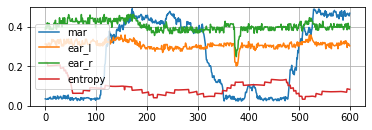

X_data = [4928,:,0], Y_data = 0.0


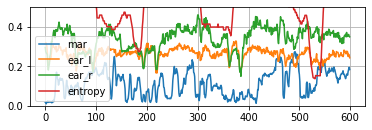

In [12]:
def drawTrain(i, num):
    plt.subplot(210 + i)
    plt.plot(X_train[num,:,0], label='mar')
    plt.plot(X_train[num,:,1], label='ear_l')
    plt.plot(X_train[num,:,2], label='ear_r')
    plt.plot(X_train[num,:,3], label='entropy')
    print(f'X_data = [{num},:,0], Y_data = {Y_train[num]}')
    plt.ylim(0, 0.5)
    plt.legend()
    plt.grid(True)
    plt.show()
def getRnd():
    return random.randint(0, X_train.shape[0] - 1)
def draw():
    while True:
        rnd = getRnd()
        if Y_train[rnd] > 0.5:
            drawTrain(1, rnd)
            break
    while True:
        rnd = getRnd()
        if Y_train[rnd] <= 0.5:
            drawTrain(2, rnd)
            break
draw()

##### 建立訓練模型

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_mar (InputLayer)          [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
input_ear (InputLayer)          [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 600, 64)      256         input_mar[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 600, 64)      256         input_ear[0][0]                  
______________________________________________________________________________________________

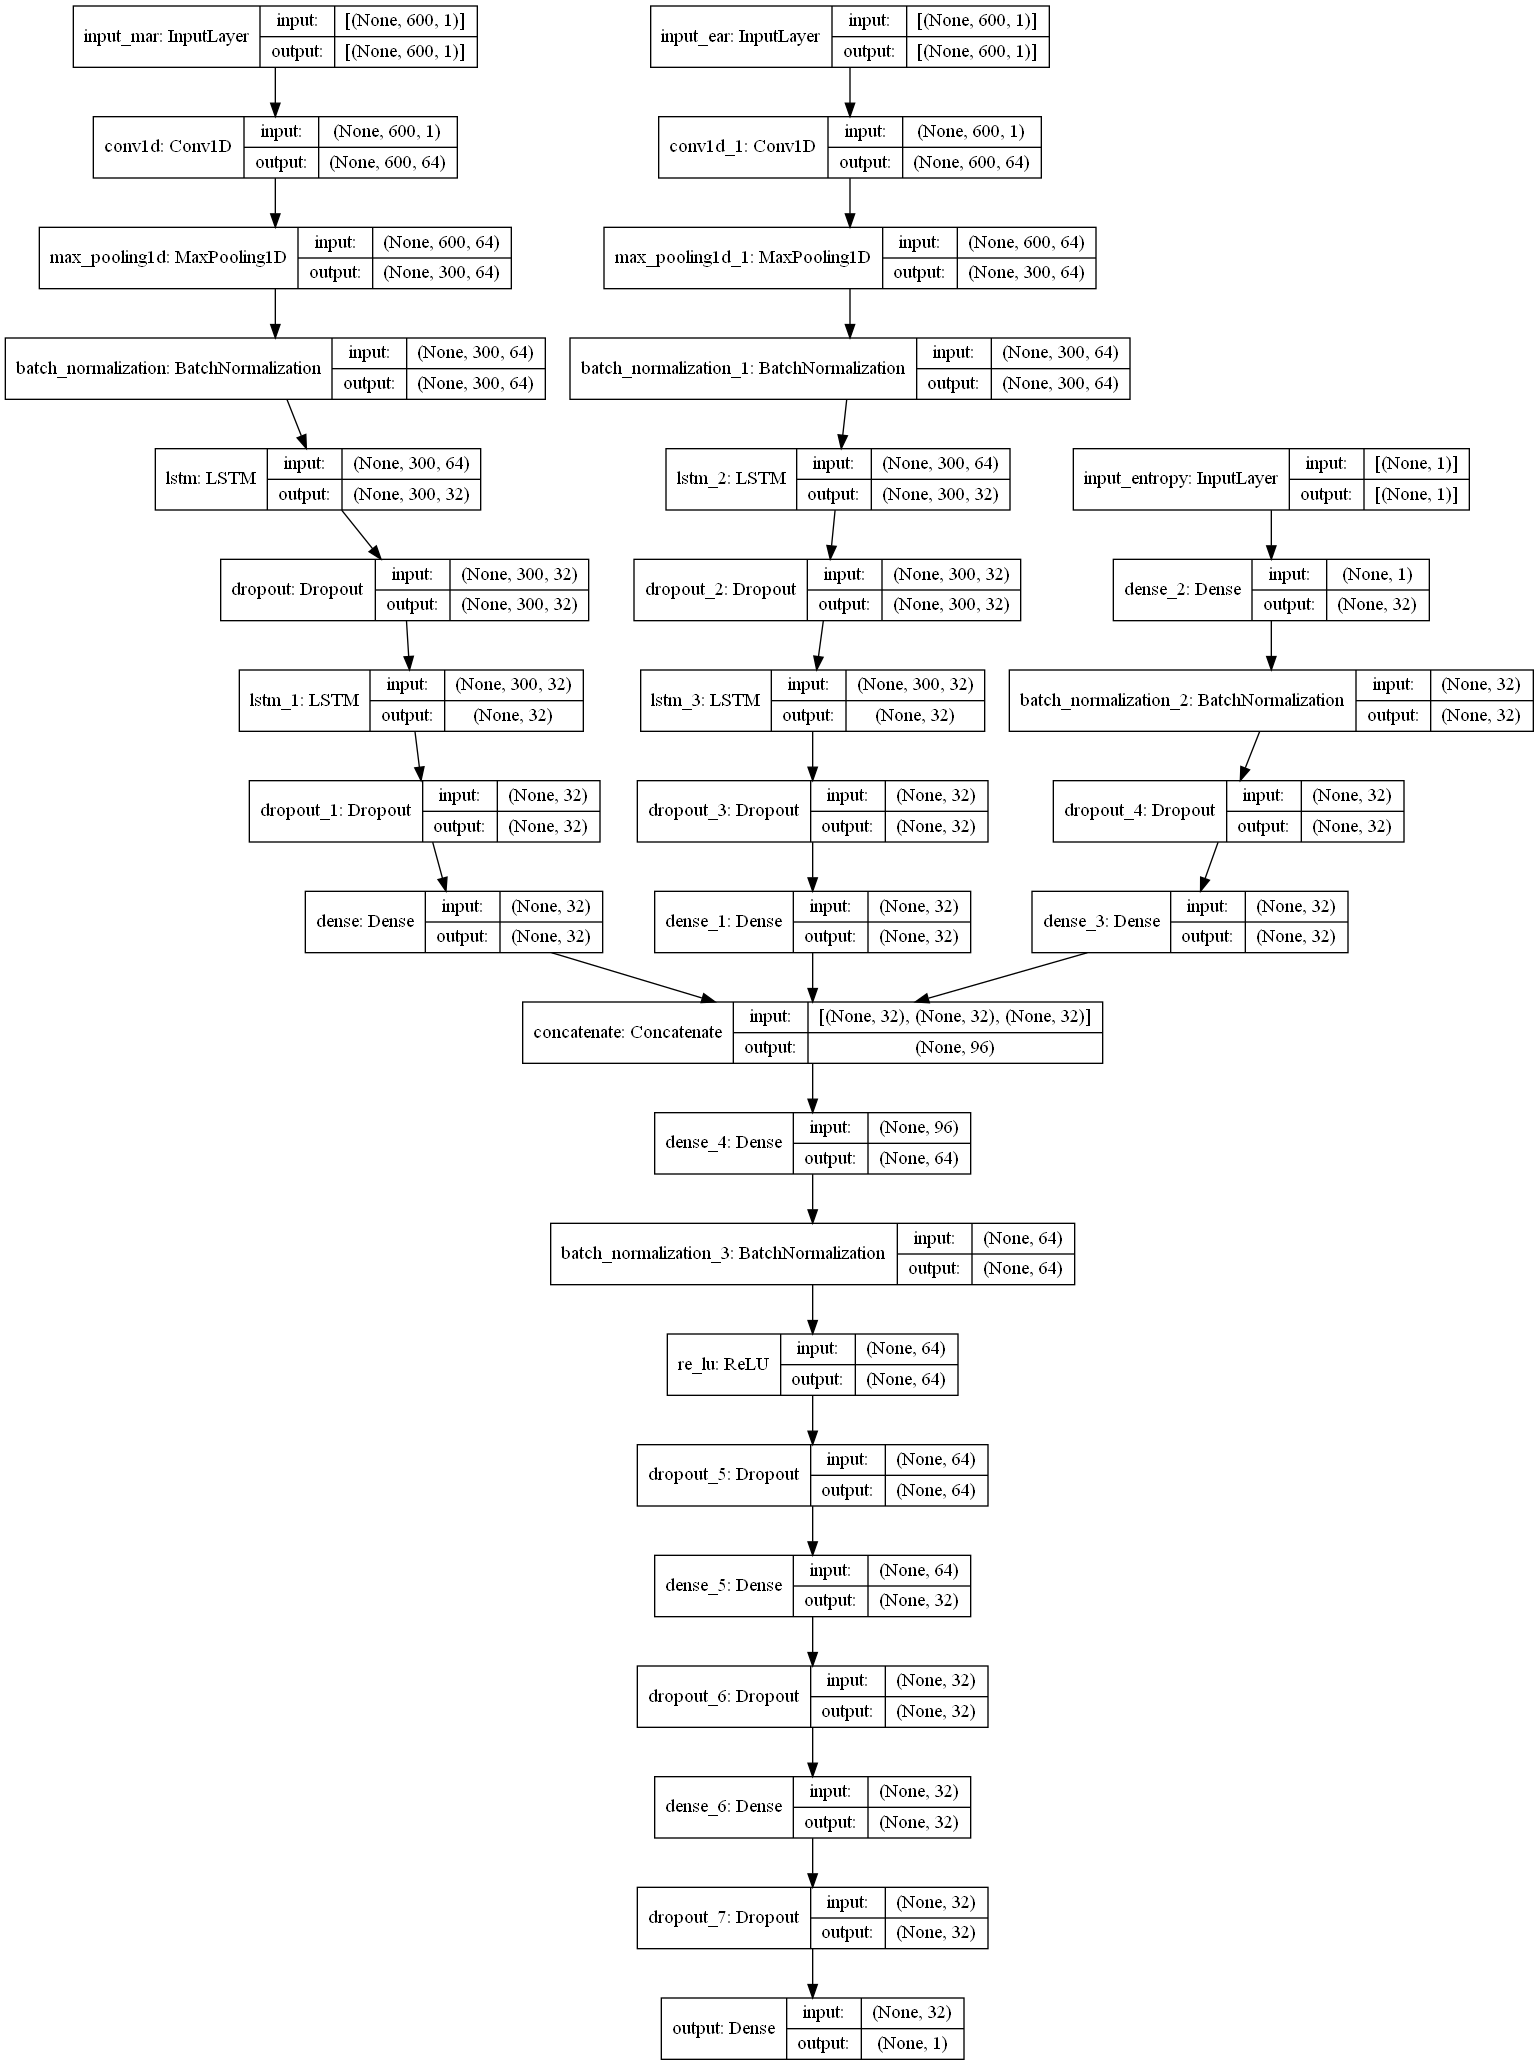

In [13]:
input_1 = keras.Input(shape=(600, 1), name='input_mar')
hidden_1 = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_1)
hidden_1 = layers.MaxPooling1D(pool_size=2, padding='valid')(hidden_1)
hidden_1 = layers.BatchNormalization()(hidden_1)
hidden_1 = layers.LSTM(32, return_sequences=True)(hidden_1)
hidden_1 = layers.Dropout(0.2)(hidden_1)
hidden_1 = layers.LSTM(32)(hidden_1)
hidden_1 = layers.Dropout(0.2)(hidden_1)
hidden_1 = layers.Dense(32, activation='relu')(hidden_1)

input_2 = keras.Input(shape=(600, 1), name='input_ear')
hidden_2 = layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(input_2)
hidden_2 = layers.MaxPooling1D(pool_size=2, padding='valid')(hidden_2)
hidden_2 = layers.BatchNormalization()(hidden_2)
hidden_2 = layers.LSTM(32, return_sequences=True)(hidden_2)
hidden_2 = layers.Dropout(0.2)(hidden_2)
hidden_2 = layers.LSTM(32)(hidden_2)
hidden_2 = layers.Dropout(0.2)(hidden_2)
hidden_2 = layers.Dense(32, activation='relu')(hidden_2)

input_3 = keras.Input(shape=(1, ), name='input_entropy')
hidden_3 = layers.Dense(32, activation="relu")(input_3)
hidden_3 = layers.BatchNormalization()(hidden_3)
hidden_3 = layers.Dropout(0.2)(hidden_3)
hidden_3 = layers.Dense(32, activation='relu')(hidden_3)

concat = layers.Concatenate(axis=-1)([hidden_1, hidden_2, hidden_3])
concat_h1 = layers.Dense(64)(concat)
concat_h1 = layers.BatchNormalization()(concat_h1)
concat_h1 = layers.ReLU()(concat_h1)
concat_h1 = layers.Dropout(0.2)(concat_h1)
concat_h1 = layers.Dense(32, activation='relu')(concat_h1)
concat_h1 = layers.Dropout(0.2)(concat_h1)
concat_h1 = layers.Dense(32, activation='relu')(concat_h1)
concat_h1 = layers.Dropout(0.2)(concat_h1)
output = layers.Dense(1, name='output')(concat_h1)

model = keras.Model(inputs=[input_1, input_2, input_3], outputs=[output])
model.summary()
plot_model(model, show_shapes=True)

##### 開始訓練

In [20]:
''' trainParam '''
model_tag = 'Conv_BN'
optimizer = "adam"
loss = "mse"
batch_size = 256
epochs = 10000
time_tag = time.strftime("%Y_%m_%d-%H_%M_%S", time.localtime())
params_num = model.count_params()
model_dir = f'{time_tag}-{model_tag}-params_{params_num}-batch_{batch_size}-optimizer_{optimizer}-loss_{loss}'
print(model_dir)
callbacks = list()
model.compile(optimizer="adam", loss="mse")
''' EarlyStopping '''
callbacks.append(
    keras.callbacks.EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
)
''' ModelCheckpoint '''
model_name = 'epoch_{epoch:03d}-val_loss_{val_loss:.3f}.hdf5'
filepath = os.path.join('models', model_dir, model_name)
callbacks.append(
    keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
)
''' TensorBoard '''
log_dir = os.path.join('models', 'logs', model_dir)
callbacks.append(
    keras.callbacks.TensorBoard(log_dir=log_dir)
)

2022_04_01-22_47_08-Conv_BN-batch_256-optimizer_adam-loss_mse


In [21]:
trainHistory = model.fit(
    x_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, Y_val),
    callbacks=callbacks
)

Epoch 1/10000
138/138 [==============================] - 26s 123ms/step - loss: 0.0402 - val_loss: 0.0178
Epoch 2/10000
138/138 [==============================] - 14s 103ms/step - loss: 0.0139 - val_loss: 0.0180
Epoch 3/10000
138/138 [==============================] - 14s 103ms/step - loss: 0.0107 - val_loss: 0.0180
Epoch 4/10000
138/138 [==============================] - 14s 103ms/step - loss: 0.0094 - val_loss: 0.0172
Epoch 5/10000
138/138 [==============================] - 14s 101ms/step - loss: 0.0066 - val_loss: 0.0108
Epoch 6/10000
138/138 [==============================] - 14s 105ms/step - loss: 0.0062 - val_loss: 0.0069
Epoch 7/10000
138/138 [==============================] - 14s 104ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 8/10000
138/138 [==============================] - 14s 104ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 9/10000
138/138 [==============================] - 15s 106ms/step - loss: 0.0061 - val_loss: 0.0049
Epoch 10/10000
138/138 [======================

**繪製Loss線**

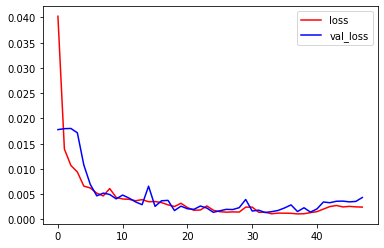

In [22]:
plt.plot(trainHistory.history['loss'], color='r', label='loss')
plt.plot(trainHistory.history['val_loss'], color='b', label='val_loss')
plt.legend()
plt.show()

### 匯出模型

In [18]:
model_file_name = f'model_{len(model.layers)}_layer_{epochs}_epoch_{batch_size}_batch.h5'
model_file_name

'model_24_layer_10000_epoch_256_batch.h5'

In [19]:
model.save(model_file_name)

# 測試模型

In [20]:
from keras.models import load_model
my_model = load_model(model_file_name)

In [ ]:
predicted = my_model.predict(X_test)
plt.plot(test_norm[100:,1], color='g', label='X_test')
plt.plot(Y_test, color='r', label='Y_test')
plt.plot(predicted, color='b', label='Predicted')
plt.legend()
plt.show()

In [25]:
predicted = model.predict(x_test)

In [28]:
predicted[predicted<0]=0

In [24]:
from time import sleep

In [26]:
for r in range(len(Y_test)):
    if Y_test[r] == 0: continue
    print(f'{Y_test[r]}, {predicted[r, 0]:.2f}')

1.0, 0.73
1.0, 0.38
0.8, 0.01
1.0, 0.71
1.0, 0.00
0.6, 0.65
1.0, 0.43
1.0, 0.73
0.6, 0.16
1.0, -0.00
1.0, 0.40
1.0, 0.40
1.0, -0.00
1.0, 0.77
0.4, 0.00
1.0, -0.00
1.0, -0.00
0.2, -0.00
1.0, 0.72
1.0, 0.00
1.0, 0.45
0.6, 0.31
1.0, -0.00
1.0, -0.00
1.0, 0.13
1.0, 0.71
1.0, -0.00
1.0, -0.00
1.0, 0.44
1.0, -0.00
1.0, -0.00
1.0, 0.00
1.0, -0.00
0.2, -0.00
0.4, -0.00
0.6, -0.00
1.0, 0.25
0.8, 0.42
0.2, -0.00
1.0, 0.00
1.0, 0.08
1.0, 0.59
1.0, 0.74
0.8, 0.39
1.0, 0.00
0.2, -0.00
0.4, 0.00
1.0, 0.44
1.0, 0.42
1.0, -0.00
0.2, -0.00
0.4, 0.00
1.0, 0.77
1.0, 0.76
1.0, -0.00
0.4, -0.00
1.0, -0.00
1.0, 0.83
1.0, 0.73
0.2, -0.00
1.0, -0.00
0.4, 0.73
1.0, 0.21
1.0, 0.00
1.0, 0.76
0.2, -0.00
0.2, -0.00
0.4, 0.00
1.0, 0.06
1.0, 0.81
1.0, 0.81
0.2, -0.00
1.0, -0.00
1.0, -0.00
1.0, -0.00
0.2, -0.00
1.0, -0.00
1.0, 0.76
1.0, -0.00
1.0, -0.00
1.0, 0.76


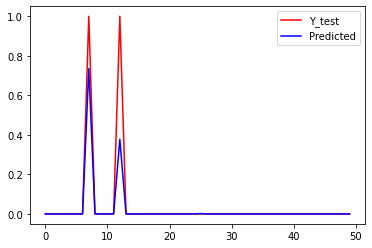

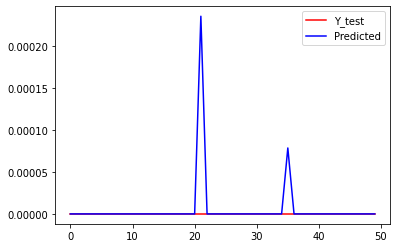

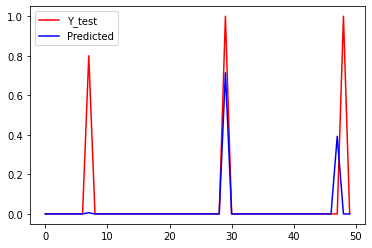

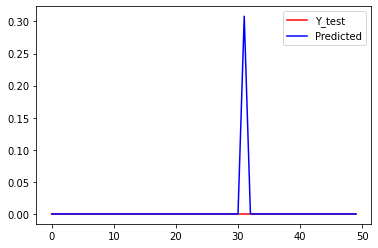

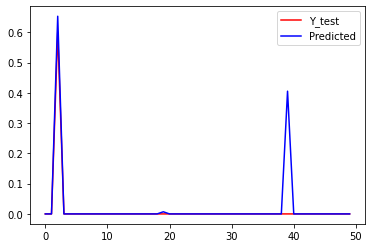

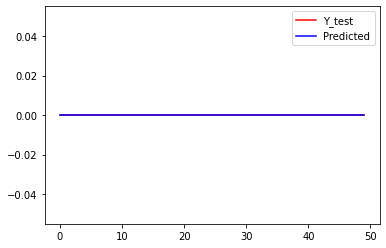

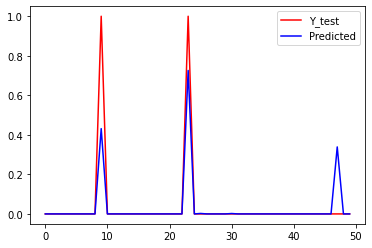

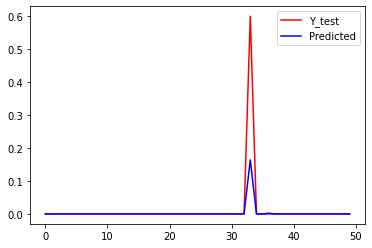

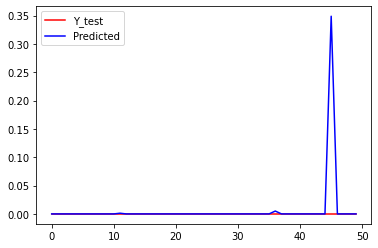

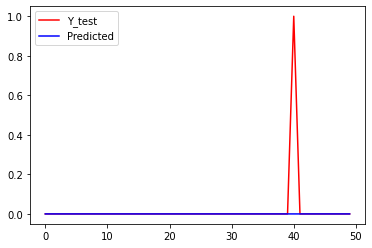

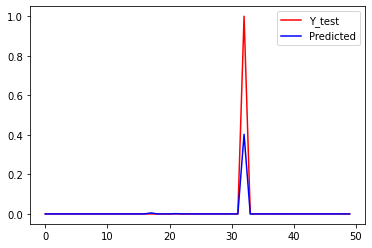

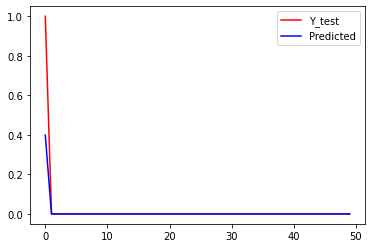

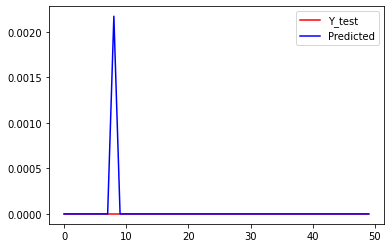

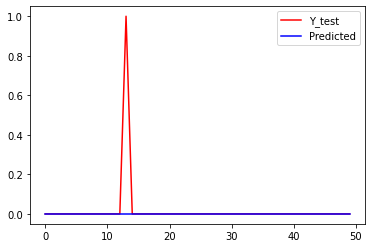

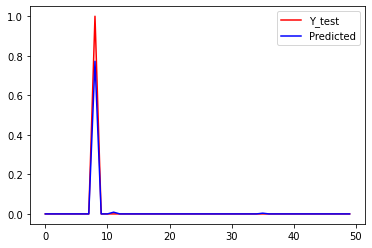

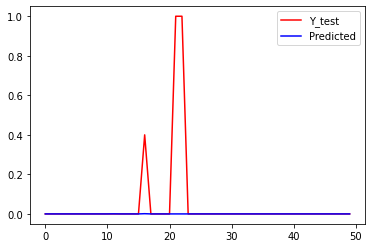

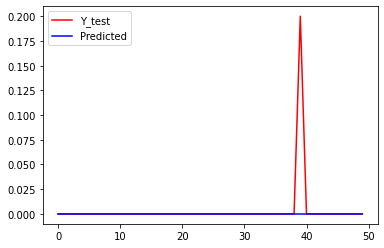

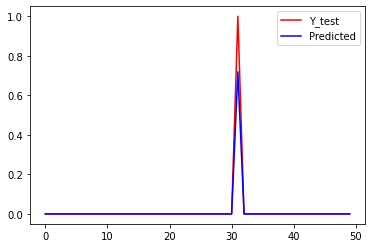

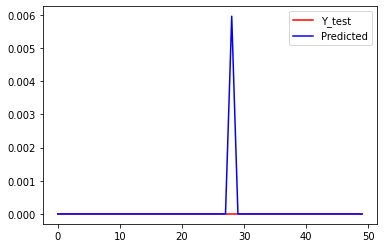

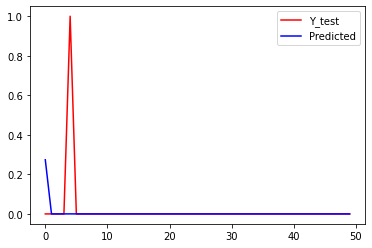

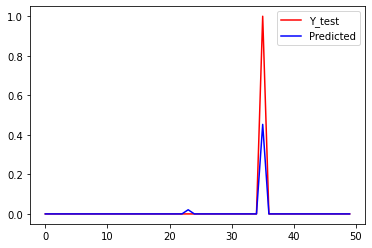

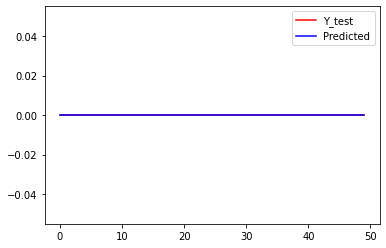

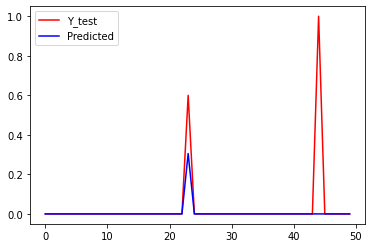

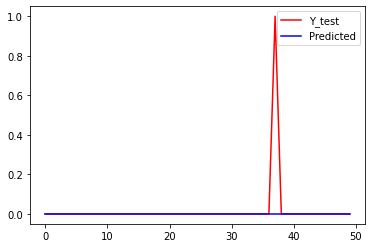

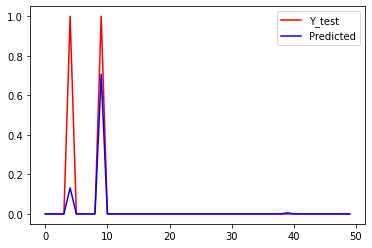

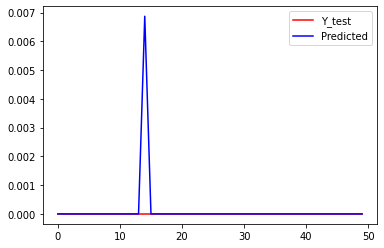

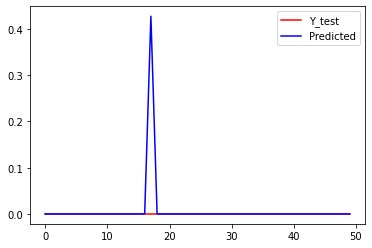

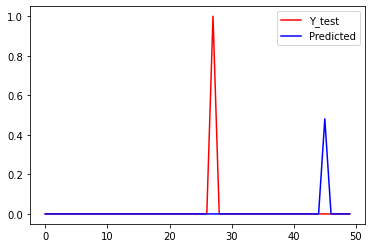

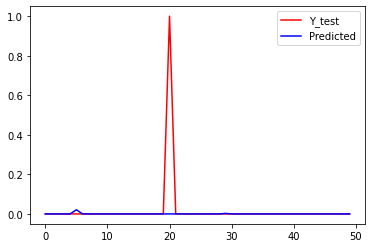

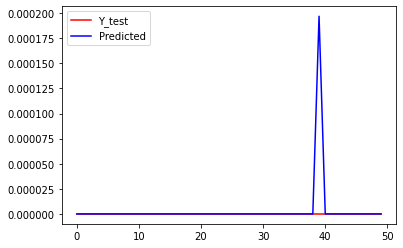

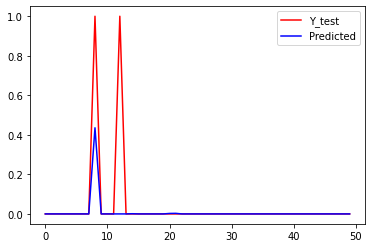

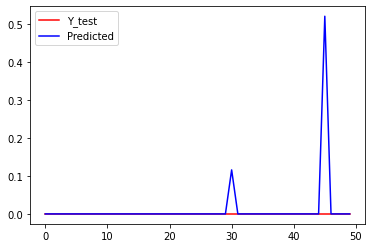

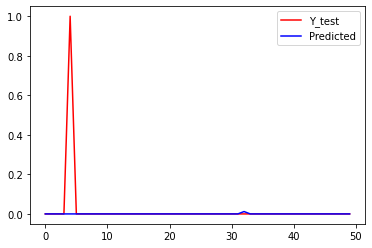

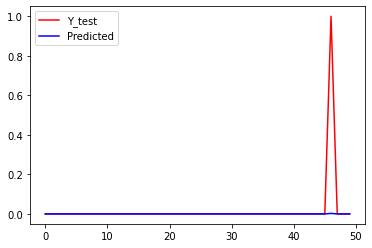

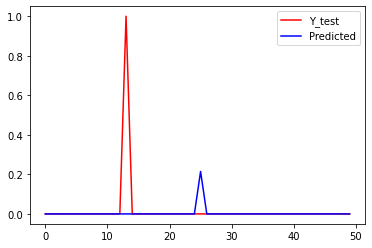

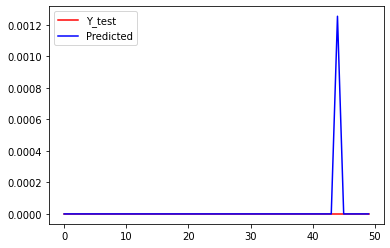

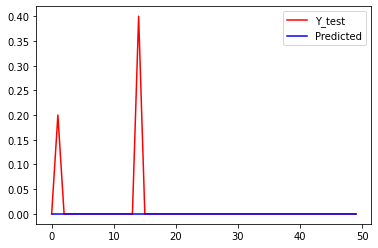

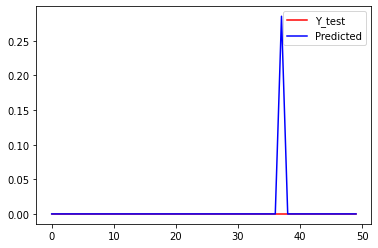

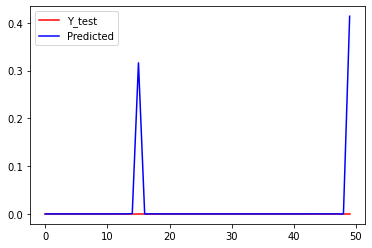

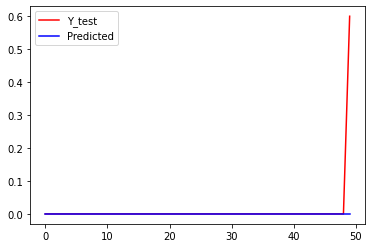

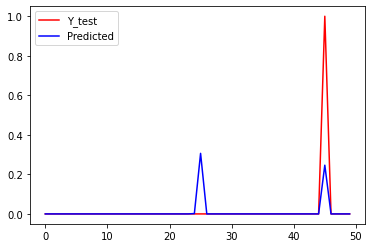

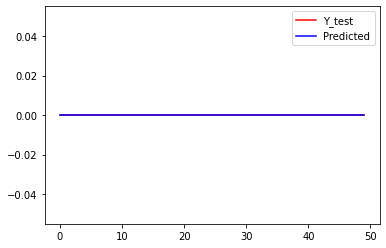

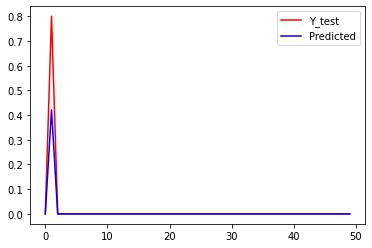

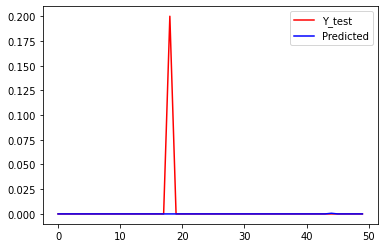

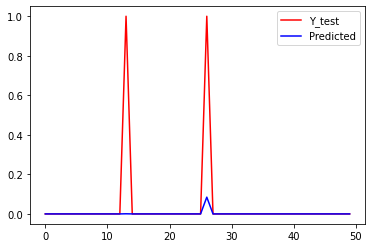

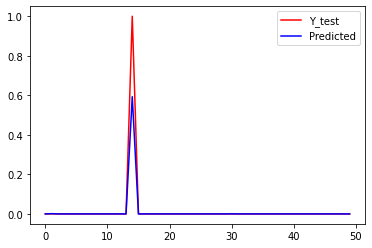

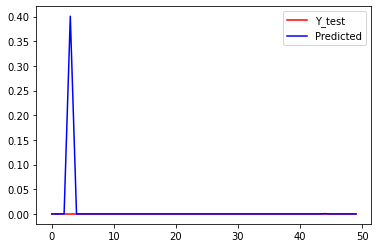

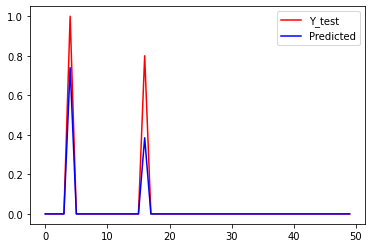

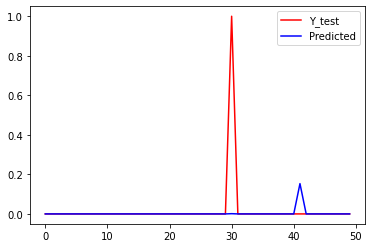

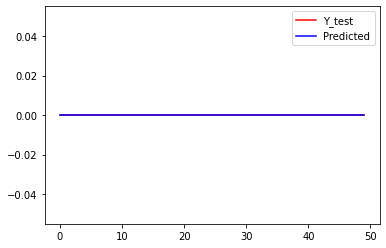

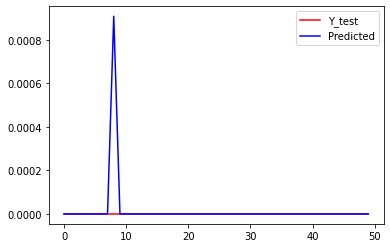

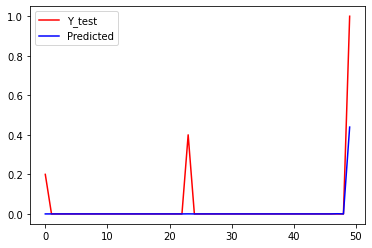

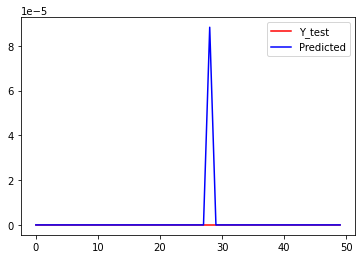

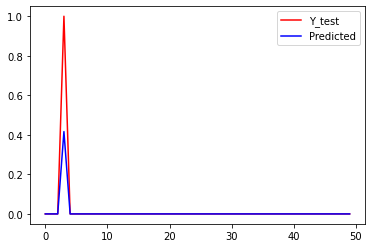

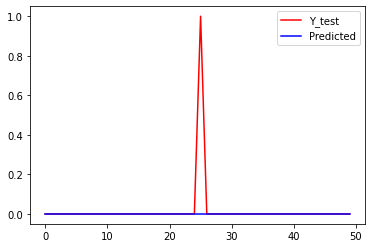

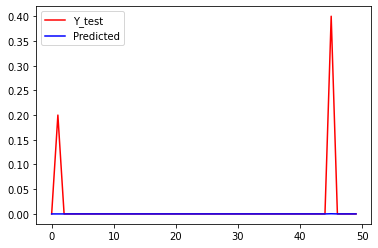

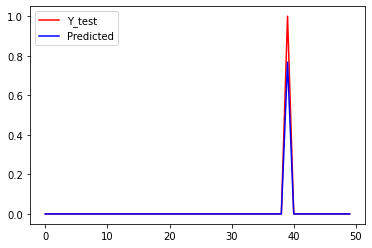

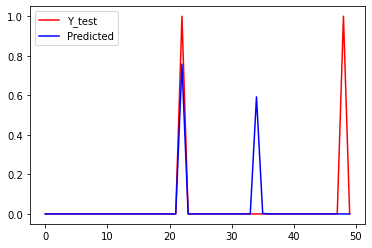

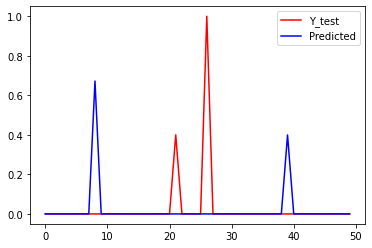

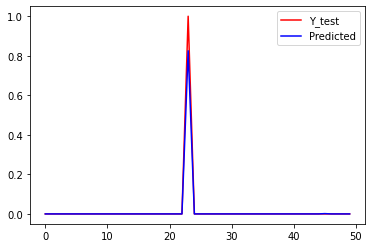

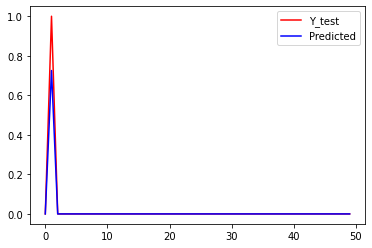

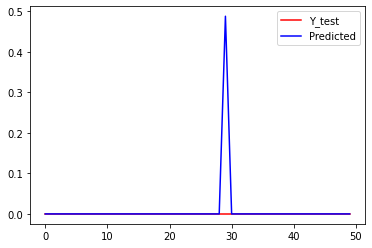

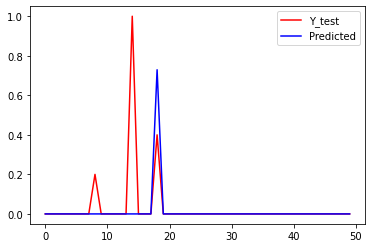

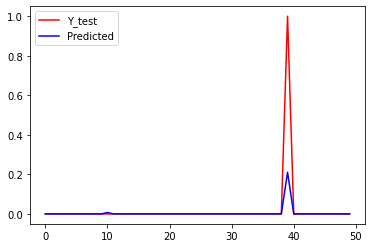

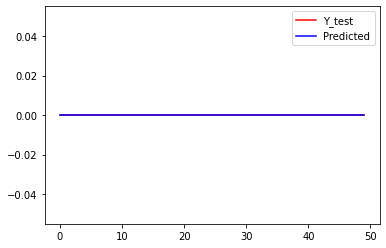

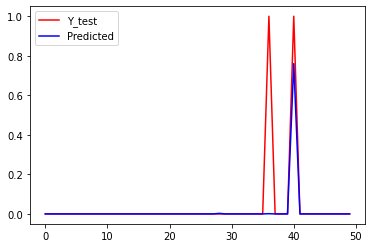

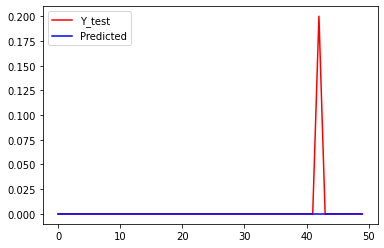

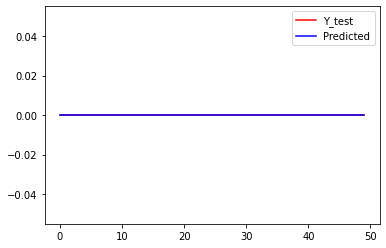

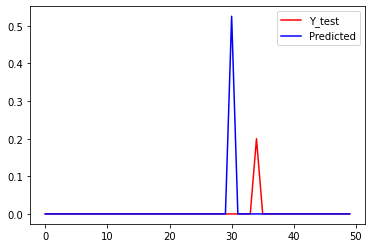

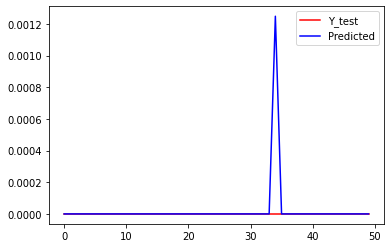

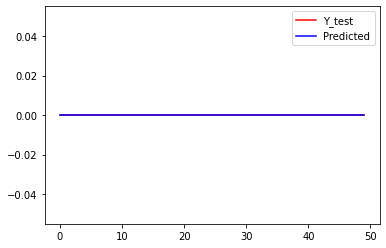

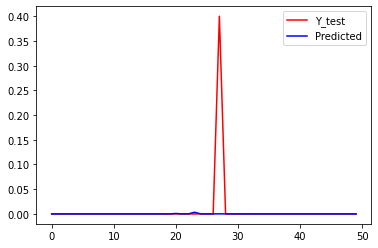

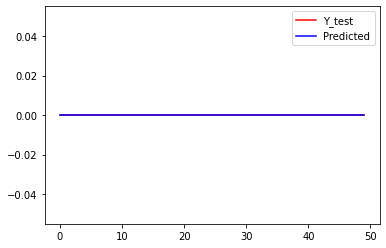

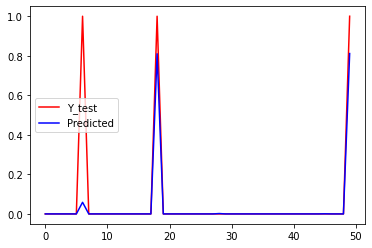

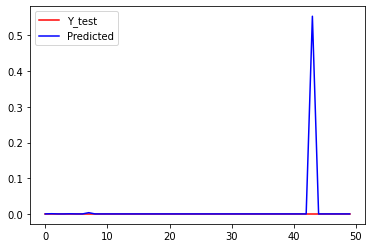

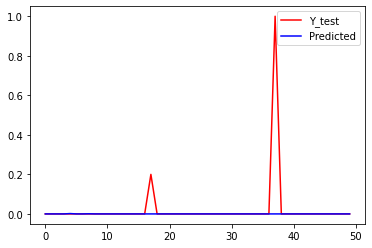

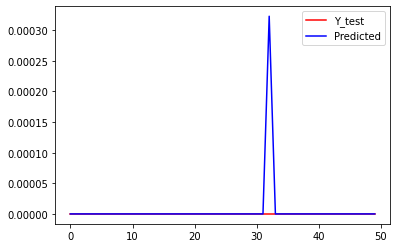

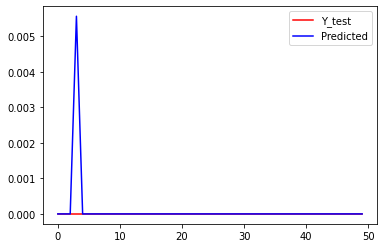

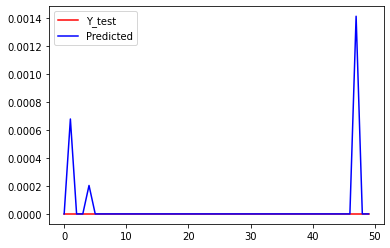

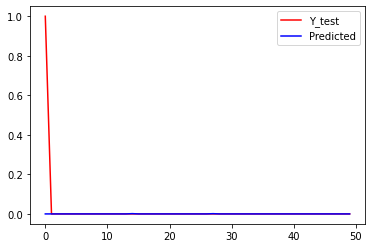

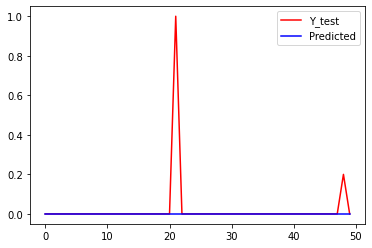

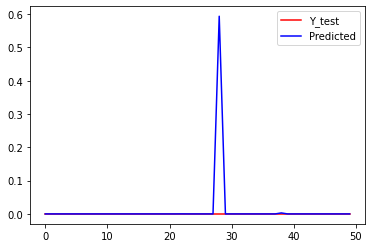

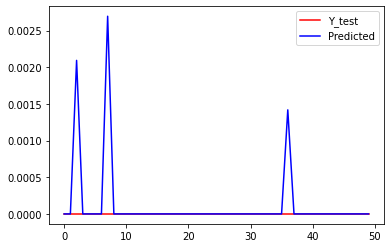

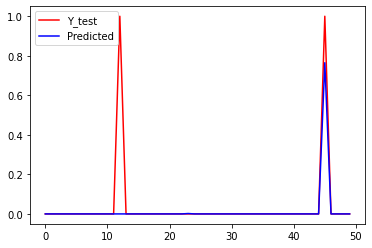

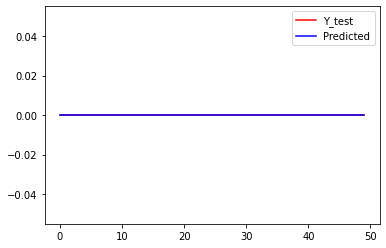

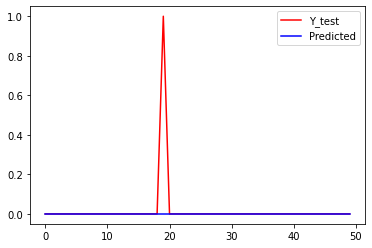

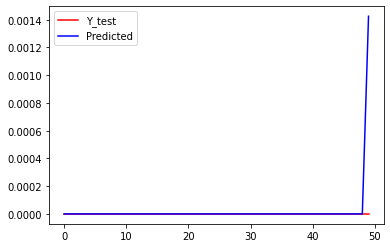

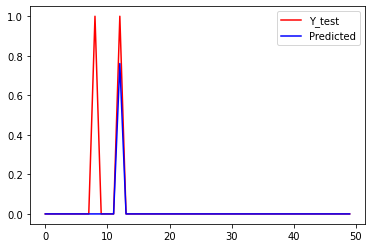

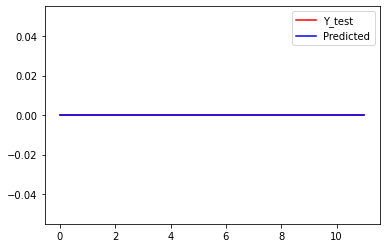

In [29]:
for r in range(0, len(Y_test), 50):
    plt.plot(Y_test[r:r+50], color='r', label='Y_test')
    plt.plot(predicted[r:r+50], color='b', label='Predicted')
    plt.legend()
    plt.show()